In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import countplot,lineplot, barplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, GroupShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
import math
from itertools import chain
from rgf.sklearn import RGFClassifier

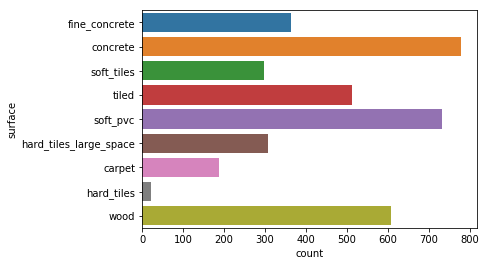

In [2]:
def quaternion_to_euler(x, y, z, w):

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def fe(actual):
    new = pd.DataFrame()
    actual['total_angular_velocity'] = np.sqrt(np.square(actual['angular_velocity_X']) + 
                                        np.square(actual['angular_velocity_Y']) + 
                                        np.square(actual['angular_velocity_Z']))
    actual['total_linear_acceleration'] = np.sqrt(np.square(actual['linear_acceleration_X']) + 
                                            np.square(actual['linear_acceleration_Y']) + 
                                            np.square(actual['linear_acceleration_Z']))
    
    actual['acc_vs_vel'] = actual['total_linear_acceleration'] / actual['total_angular_velocity']
    
    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    
    def f1(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    def f2(x):
        return np.mean(np.abs(np.diff(x)))
    
    for col in actual.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        new[col + '_mean'] = actual.groupby(['series_id'])[col].mean()
        new[col + '_min'] = actual.groupby(['series_id'])[col].min()
        new[col + '_max'] = actual.groupby(['series_id'])[col].max()
        new[col + '_std'] = actual.groupby(['series_id'])[col].std()
        new[col + '_max_to_min'] = new[col + '_max'] / new[col + '_min']
        
        # Change. 1st order.
        new[col + '_mean_abs_change'] = actual.groupby('series_id')[col].apply(f2)
        
        # Change of Change. 2nd order.
        new[col + '_mean_change_of_abs_change'] = actual.groupby('series_id')[col].apply(f1)
        
        new[col + '_abs_max'] = actual.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        new[col + '_abs_min'] = actual.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))

    return new


X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
SS = pd.read_csv('sample_submission.csv')

X_train.head()
countplot(y = 'surface', data = y_train)
plt.show()

In [3]:
# Augment hard tiles. 
# print((y_train['surface'] == 'hard_tiles'))

In [4]:
le = LabelEncoder()
y_train['surface'] = le.fit_transform(y_train['surface'])

X_train = fe(X_train)
X_test = fe(X_test)

# Imputation   
X_train.fillna(0, inplace = True)
X_test.fillna(0, inplace = True)

X_train.replace(-np.inf, 0, inplace = True)
X_train.replace(np.inf, 0, inplace = True)
X_test.replace(-np.inf, 0, inplace = True)
X_test.replace(np.inf, 0, inplace = True)
X_train.head()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_Y_mean,...,euler_y_abs_min,euler_z_mean,euler_z_min,euler_z_max,euler_z_std,euler_z_max_to_min,euler_z_mean_abs_change,euler_z_mean_change_of_abs_change,euler_z_abs_max,euler_z_abs_min
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75953,-0.75822,0.000363,0.998275,0.000015,2.380952e-07,0.75953,0.75822,-0.634008,...,0.023562,1.396035,1.393233,1.397402,0.001221,1.002992,0.000051,1.602451e-07,1.397402,1.393233
1,-0.958606,-0.95896,-0.95837,0.000151,0.999385,0.000023,-4.761905e-07,0.95896,0.95837,0.241867,...,0.009109,-0.492731,-0.494641,-0.490164,0.001131,0.990949,0.000147,1.303804e-07,0.494641,0.490164
2,-0.512057,-0.51434,-0.50944,0.001377,0.990473,0.000041,0.000000e+00,0.51434,0.50944,-0.846171,...,0.011795,2.055021,2.049684,2.061288,0.003219,1.005661,0.000097,-8.169853e-07,2.061288,2.049684
3,-0.939169,-0.93968,-0.93884,0.000227,0.999106,0.000026,-6.349206e-07,0.93968,0.93884,0.310140,...,0.014645,-0.635656,-0.638340,-0.634294,0.000931,0.993661,0.000071,9.790398e-08,0.638340,0.634294
4,-0.891301,-0.89689,-0.88673,0.002955,0.988672,0.000080,7.936508e-08,0.89689,0.88673,0.428144,...,0.009358,-0.894147,-0.915040,-0.867983,0.013836,0.948575,0.000371,4.805791e-07,0.915040,0.867983


In [5]:
'''
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest Accuracy: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))

# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = RandomForestClassifier(
        criterion='gini',
        verbose=1,
        max_features='auto',
        max_leaf_nodes=None,
        random_state = 1337
        
    ),
    search_spaces = { 
        'max_depth': (1, 200),
        'n_estimators': (20, 300),
        'min_samples_split': (2,20),
        'min_samples_leaf': (1,10),
        'min_weight_fraction_leaf': (0.0,0.5),
        'min_impurity_decrease': (0,1E-7),
        
        
    },    
    cv = StratifiedKFold(n_splits=split_count, shuffle=True, random_state=546789),
    n_jobs = -1,
    n_iter = 40,   
    verbose = 1,
    refit = True,
    
)

# Fit the model
result = bayes_cv_tuner.fit(X_train, y_train['surface'], groups=y_train['group_id'], callback=status_print)

'''


'\ndef status_print(optim_result):\n    """Status callback durring bayesian hyperparameter search"""\n    \n    # Get all the models tested so far in DataFrame format\n    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    \n    \n    # Get current parameters and the best parameters    \n    best_params = pd.Series(bayes_cv_tuner.best_params_)\n    print(\'Model #{}\nBest Accuracy: {}\nBest params: {}\n\'.format(\n        len(all_models),\n        np.round(bayes_cv_tuner.best_score_, 4),\n        bayes_cv_tuner.best_params_\n    ))\n\n# Classifier\nbayes_cv_tuner = BayesSearchCV(\n    estimator = RandomForestClassifier(\n        criterion=\'gini\',\n        verbose=1,\n        max_features=\'auto\',\n        max_leaf_nodes=None,\n        random_state = 1337\n        \n    ),\n    search_spaces = { \n        \'max_depth\': (1, 200),\n        \'n_estimators\': (20, 300),\n        \'min_samples_split\': (2,20),\n        \'min_samples_leaf\': (1,10),\n        \'min_weight_fraction_le

____________________ 0 ____________________
train_score  0.9818754925137904
cv_score  0.8710691823899371
____________________ 1 ____________________
train_score  0.9775590551181103
cv_score  0.8700787401574803
____________________ 2 ____________________
train_score  0.977183320220299
cv_score  0.8714511041009464
____________________ 3 ____________________
train_score  0.9777424483306836
cv_score  0.5849624060150376
____________________ 4 ____________________
train_score  0.980078380143697
cv_score  0.570855614973262
____________________ 5 ____________________
train_score  0.9817320703653586
cv_score  0.42271662763466045
________________________________________
Avg CV Accuracy 0.6985222792118874

 ____________CV CONF MATS____________


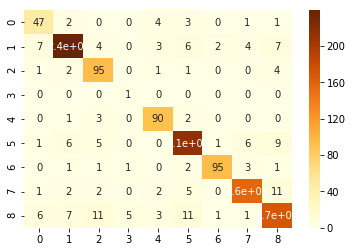

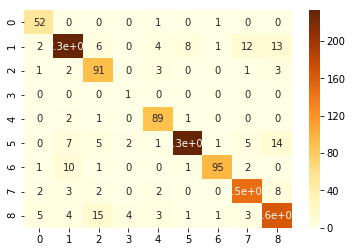

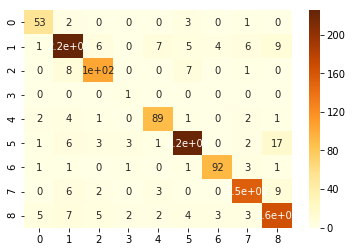

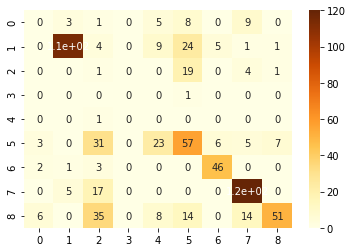

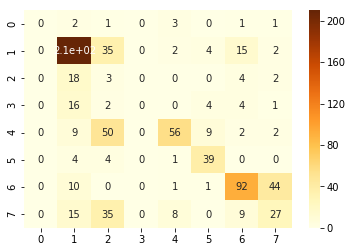

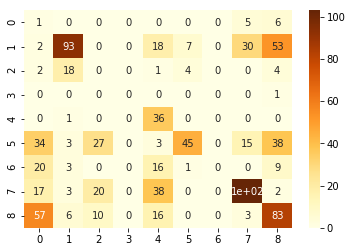

In [8]:
split_count = 3
folds = StratifiedKFold(n_splits=split_count, shuffle=True, random_state=1337)
folds_2 = GroupShuffleSplit(n_splits=split_count, random_state=1337)
sub_preds = np.zeros((X_test.shape[0], 9))
score_sum = 0
'''
clf = LGBMClassifier(colsample_bytree=0.03581900508076567, learning_rate=0.09308743154192588, 
                     max_bin=471, max_depth=-1, min_child_samples=50, min_child_weight=10, 
                     n_estimators=51, num_leaves=82, reg_alpha=2.0036361362515476e-07, reg_lambda=0.2069846982564452,
                     scale_pos_weight=9.05248363351552, subsample=0.9056112605172989, subsample_for_bin=368683, 
                     subsample_freq=9)
'''
# clf = XGBClassifier(tree_method = 'gpu_hist')


# clf = RandomForestClassifier(max_depth=77, min_impurity_decrease=8.435373293206687e-08, 
#                            min_samples_leaf=10, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=170, random_state=1337, class_weight = 'balanced')

# clf = RandomForestClassifier(max_depth=65, min_impurity_decrease=9.756650941323682e-08, min_samples_leaf=1, min_samples_split=3,
#                               min_weight_fraction_leaf=0.0, n_estimators=300, class_weight='balanced_subsample')


'''
clf = RandomForestClassifier(n_estimators = 200, n_jobs =- 1, class_weight ={0: 3810.0/189.0}, {1: 3810.0/732.0},
                            {2: 3810.0/779.0}, {3: 3810.0/21.0}, {4: 3810.0/308.0}, {5: 3810.0/363.0}, {6: 3810.0/297.0}, 
                            {7: 3810.0/514.0}, {8: 3810.0/607.0})
'''
# clf = RandomForestClassifier(n_estimators = 200, n_jobs =- 1)

clf = RGFClassifier(max_leaf=400, algorithm="RGF_Sib", test_interval=100, verbose=False)

# Training and cross validation.
for i, (train_index, test_index) in enumerate(chain(folds.split(X_train, y_train['surface']),folds_2.split(X_train, y_train['surface'],
                                                 groups=y_train['group_id']))):

    print('_'*20, i, '_'*20)
    clf.fit(X_train.iloc[train_index], y_train['surface'][train_index])
    score_sum += clf.score(X_train.iloc[test_index], y_train['surface'][test_index])
    print('train_score ', clf.score(X_train.iloc[train_index], y_train['surface'][train_index]))
    print('cv_score ', clf.score(X_train.iloc[test_index], y_train['surface'][test_index]))
    plt.figure()
    cm = confusion_matrix(clf.predict(X_train.iloc[test_index]), y_train['surface'].iloc[test_index])
    sns.heatmap(cm, annot=True, cmap="YlOrBr")
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    features = X_train.columns
    
    '''
    hm = 30
    plt.figure(figsize=(7, 10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
    plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    '''
    

print('_'*40)
mean_cv_acc = score_sum / (split_count*2)
print('Avg CV Accuracy', mean_cv_acc)
clf.fit(X_train, y_train['surface'])
sub_preds = clf.predict_proba(X_test)
print("\n ____________CV CONF MATS____________")
SS['surface'] = le.inverse_transform(sub_preds.argmax(axis=1))
SS.to_csv('rf.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(clf.predict(X_train), y_train['surface'])
sns.heatmap(cm, annot=True, cmap="YlGnBu")

In [13]:
print(y_train['surface'].value_counts())

1    779
5    732
8    607
7    514
2    363
4    308
6    297
0    189
3     21
Name: surface, dtype: int64


In [14]:
print(le.inverse_transform(y_train['surface'].unique()))
print(y_train['surface'].unique())

['fine_concrete' 'concrete' 'soft_tiles' 'tiled' 'soft_pvc'
 'hard_tiles_large_space' 'carpet' 'hard_tiles' 'wood']
[2 1 6 7 5 4 0 3 8]


In [15]:
print("Training group id occurances and conf mat.")    
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'],
                                                groups=y_train['group_id'])):
    print((y_train['group_id'].iloc[test_index]).value_counts())

Training group id occurances and conf mat.
45    28
47    28
54    28
22    27
34    27
35    26
53    26
42    25
44    25
38    25
65    25
48    24
25    24
72    24
59    24
15    24
69    23
19    23
32    23
71    23
66    22
43    22
6     22
68    22
14    22
12    21
41    21
20    21
55    21
60    21
      ..
26    17
4     17
33    17
61    17
39    17
10    17
70    16
7     16
8     16
11    16
1     15
46    15
21    14
18    14
13    13
36    12
9     11
28    11
56     9
27     7
63     7
37     6
17     6
58     4
2      4
67     3
5      3
52     2
50     2
24     2
Name: group_id, Length: 72, dtype: int64
46    30
70    28
47    27
62    26
55    26
45    25
60    25
59    25
3     25
9     24
41    24
13    24
43    24
39    24
32    24
54    24
53    24
61    23
11    23
48    22
21    22
33    22
10    22
72    22
40    21
71    21
0     21
49    21
69    21
65    20
      ..
19    18
31    17
29    17
20    16
12    16
28    16
37    16
15    15
16    15
22    1

In [16]:
print("\n\nCV group id counts.")    
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'],
                                                groups=y_train['group_id'])):    
    print((y_train['group_id'].iloc[test_index]).value_counts())
    
print("\n\nTraining label counts.")    
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'],
                                                groups=y_train['group_id'])):
    print((y_train['surface'].iloc[train_index]).value_counts())
    
print("\n\nCV label counts.")    
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'],
                                                groups=y_train['group_id'])):    
    print((y_train['surface'].iloc[test_index]).value_counts())



CV group id counts.
45    28
47    28
54    28
22    27
34    27
35    26
53    26
42    25
44    25
38    25
65    25
48    24
25    24
72    24
59    24
15    24
69    23
19    23
32    23
71    23
66    22
43    22
6     22
68    22
14    22
12    21
41    21
20    21
55    21
60    21
      ..
26    17
4     17
33    17
61    17
39    17
10    17
70    16
7     16
8     16
11    16
1     15
46    15
21    14
18    14
13    13
36    12
9     11
28    11
56     9
27     7
63     7
37     6
17     6
58     4
2      4
67     3
5      3
52     2
50     2
24     2
Name: group_id, Length: 72, dtype: int64
46    30
70    28
47    27
62    26
55    26
45    25
60    25
59    25
3     25
9     24
41    24
13    24
43    24
39    24
32    24
54    24
53    24
61    23
11    23
48    22
21    22
33    22
10    22
72    22
40    21
71    21
0     21
49    21
69    21
65    20
      ..
19    18
31    17
29    17
20    16
12    16
28    16
37    16
15    15
16    15
22    15
36    15
25    15
6